# Retrieve sensor log from Raspberry Pi and graph it

In [1]:
# read raspberry pi access data from secrets file
# Add path to my library
import sys
sys.path.append(r'/Users/alvazi2/Documents/PythonPrograms/AlvaziLib')
import Secrets
PATH = "/Users/alvazi2/Documents/JupyterLab/Secrets/"
SECRETS_FILENAME = "AlvaziSecrets.json"
secrets = Secrets.AlvaziSecrets(PATH, SECRETS_FILENAME)

In [2]:
from platform import python_version
print(python_version())

3.10.4


In [3]:
from paramiko import SSHClient
from scp import SCPClient

RaspberryPi = secrets.secret("Raspberry Pi 2013")["IP"]
MyUser = secrets.secret("Raspberry Pi 2013")["USER"]
MyPassword = secrets.secret("Raspberry Pi 2013")["PASSWORD"]
RemotePath = 'Adafruit_Python_BMP/'
LogFile = 'sensor_log.csv'

# copy sensor log from my Raspberry Pi
ssh = SSHClient() #secure shell SSH connection
ssh.load_system_host_keys()
ssh.connect(RaspberryPi, username=MyUser, password=MyPassword, look_for_keys=False)
scp = SCPClient(ssh.get_transport())
scp.get(RemotePath+LogFile)
scp.close()

In [4]:
# read sensor log file (CSV format) into pandas dataframe object
from pandas import read_csv, to_datetime, DataFrame, Timestamp
sensorLog = read_csv(LogFile, index_col=0, parse_dates=True)
# round timestamp to full minutes
sensorLog.index = to_datetime(sensorLog.index.map(lambda t: t.strftime('%Y-%m-%d %H:%M')))
# print most recent 10 sensor log entries
sensorLog.tail(10)

,Temp,Pressure,Altitude,Sealevel Pressure
TimeStamp,,,,
2023-01-16 14:45:00,13.2,100109.0,101.48,100102.0
2023-01-16 15:00:00,13.2,100098.0,102.24,100106.0
2023-01-16 15:15:00,13.2,100133.0,99.97,100130.0
2023-01-16 15:30:00,13.3,100140.0,99.38,100136.0
2023-01-16 15:45:00,13.4,100166.0,97.45,100164.0
2023-01-16 16:00:00,13.2,100167.0,96.35,100176.0
2023-01-16 16:15:00,13.3,100194.0,94.76,100191.0
2023-01-16 16:30:00,13.1,100205.0,93.33,100216.0
2023-01-16 16:45:00,13.0,100215.0,92.74,100222.0


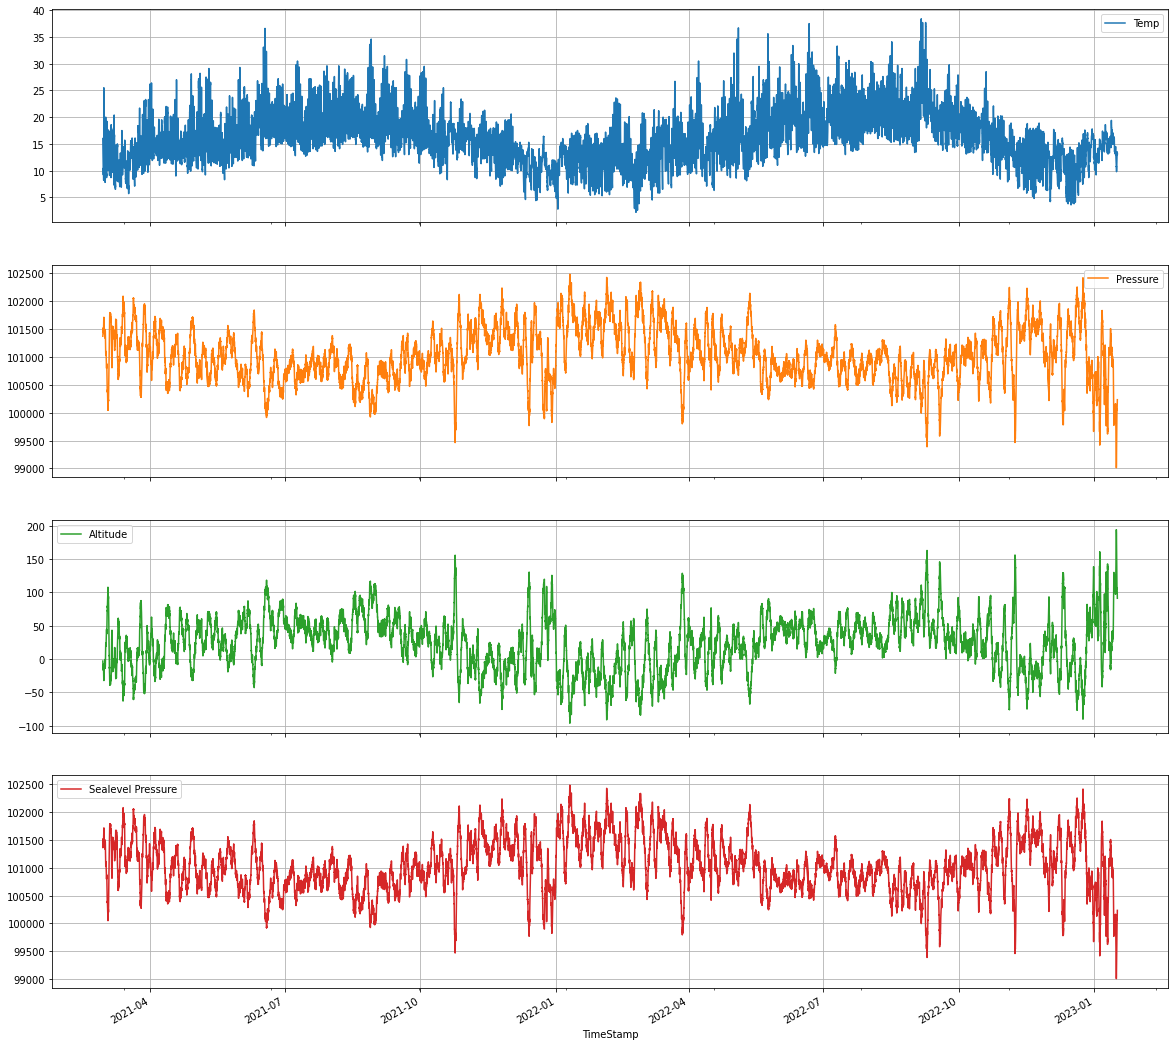

In [5]:
import matplotlib.pyplot as plt

# plot all data columns
axs = sensorLog.plot(figsize=(20,20), grid=True, subplots=True)

2023-01-16


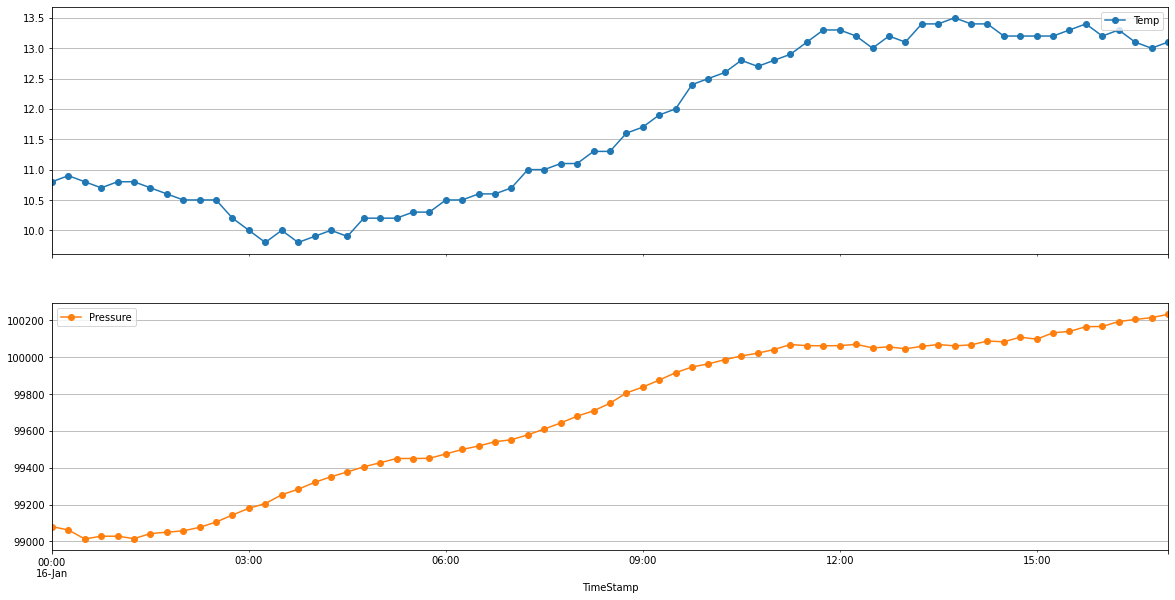

In [6]:
import datetime
today = datetime.date.today().isoformat()
print(today)
# plot today's temperature and pressure
axs = sensorLog.loc[today:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, marker='o', subplots=True)

In [7]:
print(sensorLog.loc[today:today].describe())

            Temp       Pressure    Altitude  Sealevel Pressure
count  69.000000      69.000000   69.000000          69.000000
mean   11.717391   99686.681159  137.235072       99688.231884
std     1.310810     410.290266   34.529420         409.120511
min     9.800000   99013.000000   90.980000       99007.000000
25%    10.500000   99351.000000  105.600000       99349.000000
50%    11.300000   99750.000000  131.960000       99753.000000
75%    13.100000  100063.000000  165.660000      100067.000000
max    13.500000  100233.000000  193.860000      100235.000000


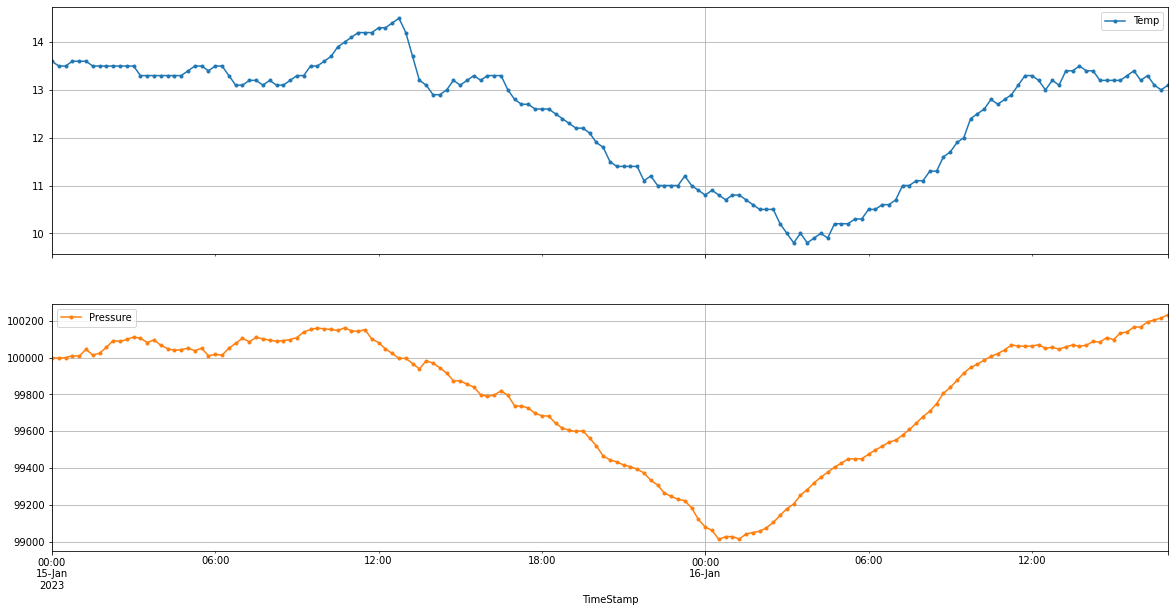

In [8]:
# plot yesterday's and today's temperature and pressure
yesterday = (datetime.date.today() - datetime.timedelta(days = 1)).isoformat()
axs = sensorLog.loc[yesterday:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, marker='.', subplots=True)

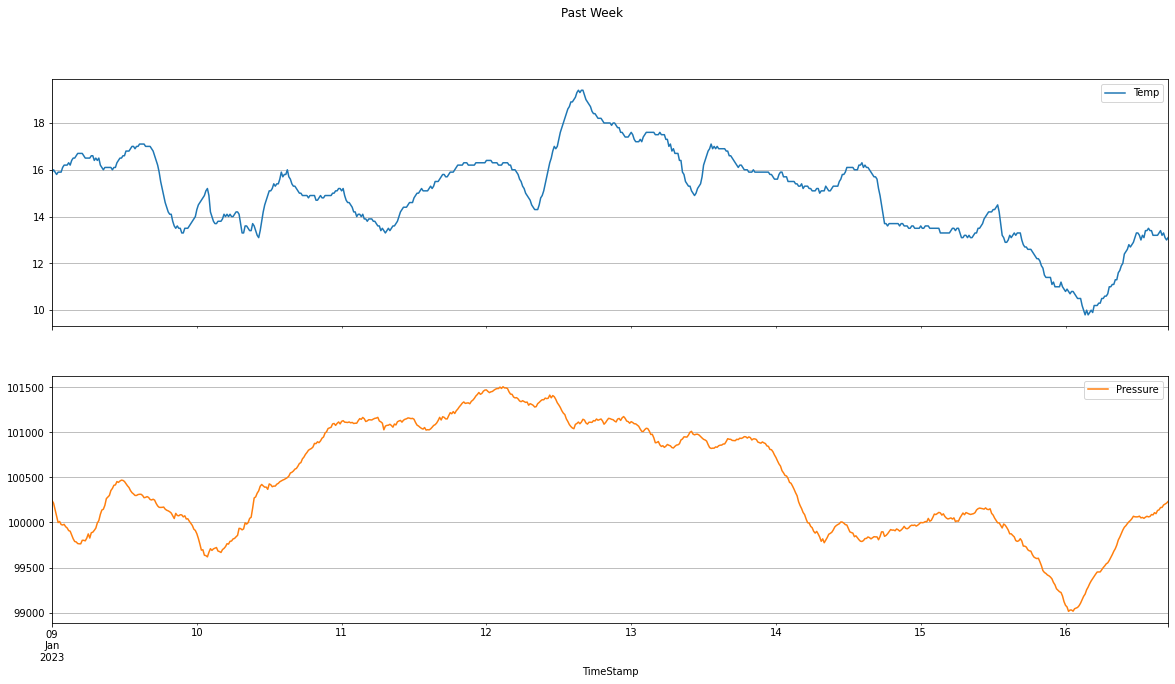

In [9]:
# plot past week's temperature and pressure
weekago = (datetime.date.today() - datetime.timedelta(weeks = 1)).isoformat() 
axs = sensorLog.loc[weekago:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True, title='Past Week')
# save plot as file
plt.savefig('pastWeekPlot')

In [10]:
sensorLog.axes

[DatetimeIndex(['2021-02-27 17:03:00', '2021-02-27 17:15:00',
                '2021-02-27 17:30:00', '2021-02-27 17:45:00',
                '2021-02-27 18:00:00', '2021-02-27 18:15:00',
                '2021-02-27 18:30:00', '2021-02-27 18:45:00',
                '2021-02-27 19:00:00', '2021-02-27 19:15:00',
                ...
                '2023-01-16 14:45:00', '2023-01-16 15:00:00',
                '2023-01-16 15:15:00', '2023-01-16 15:30:00',
                '2023-01-16 15:45:00', '2023-01-16 16:00:00',
                '2023-01-16 16:15:00', '2023-01-16 16:30:00',
                '2023-01-16 16:45:00', '2023-01-16 17:00:00'],
               dtype='datetime64[ns]', name='TimeStamp', length=66027, freq=None),
 Index(['Temp', 'Pressure', 'Altitude', 'Sealevel Pressure'], dtype='object')]

In [11]:
sensorLog.loc[weekago:today].agg(['min', 'max', 'mean'])

,Temp,Pressure,Altitude,Sealevel Pressure
min,9.800000,99013.000000,-16.220000,99007.000000
max,19.400000,101507.000000,193.860000,101509.000000
mean,14.940486,100447.363023,73.320081,100449.230769


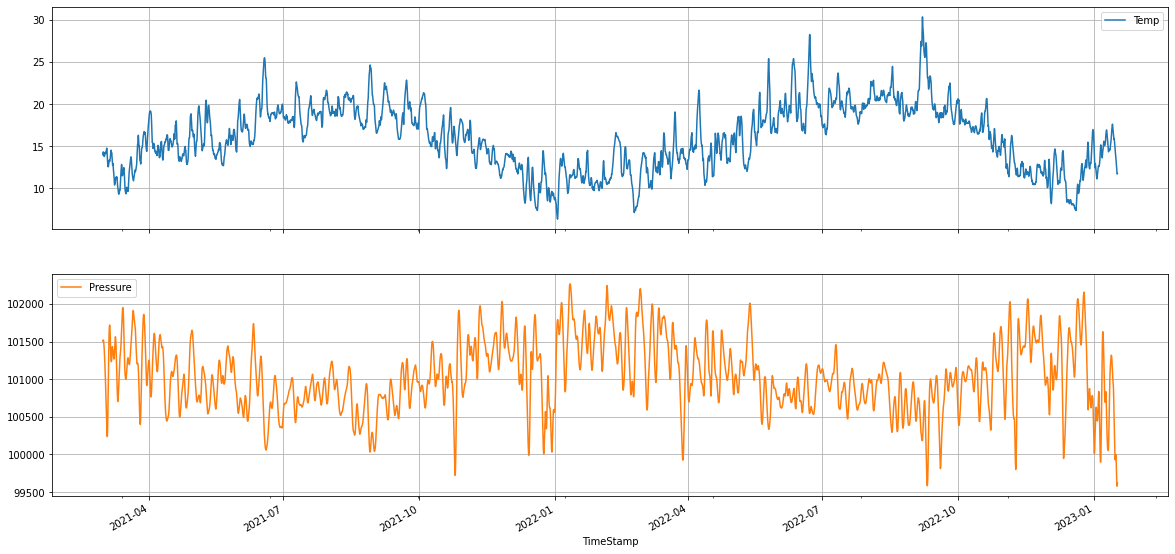

In [12]:
# 1-day rolling average
axs = sensorLog.rolling(24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True)

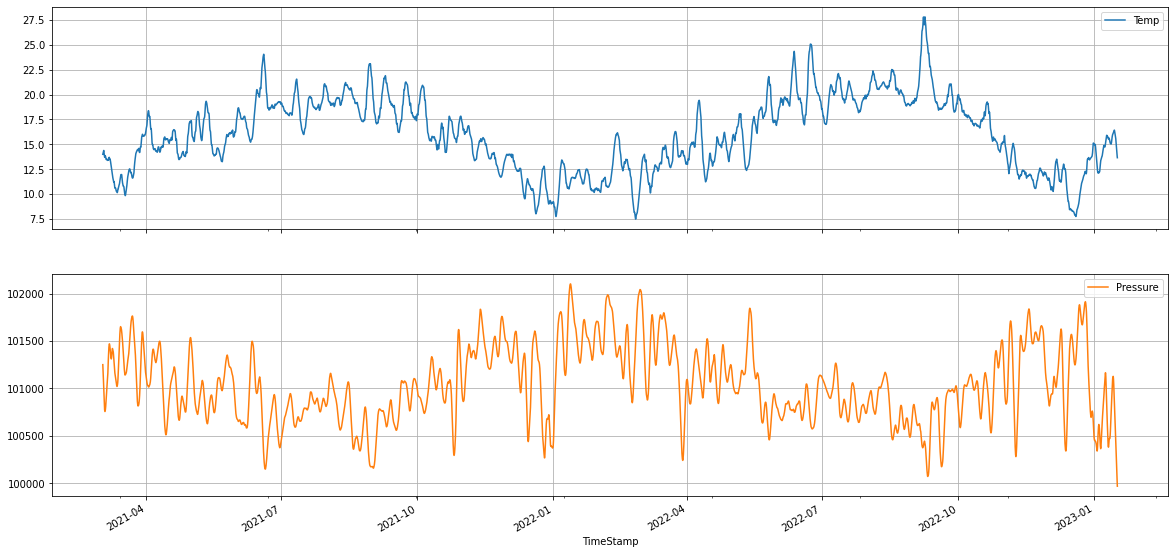

In [13]:
# 3 days rolling average
axs = sensorLog.rolling(3*24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True)

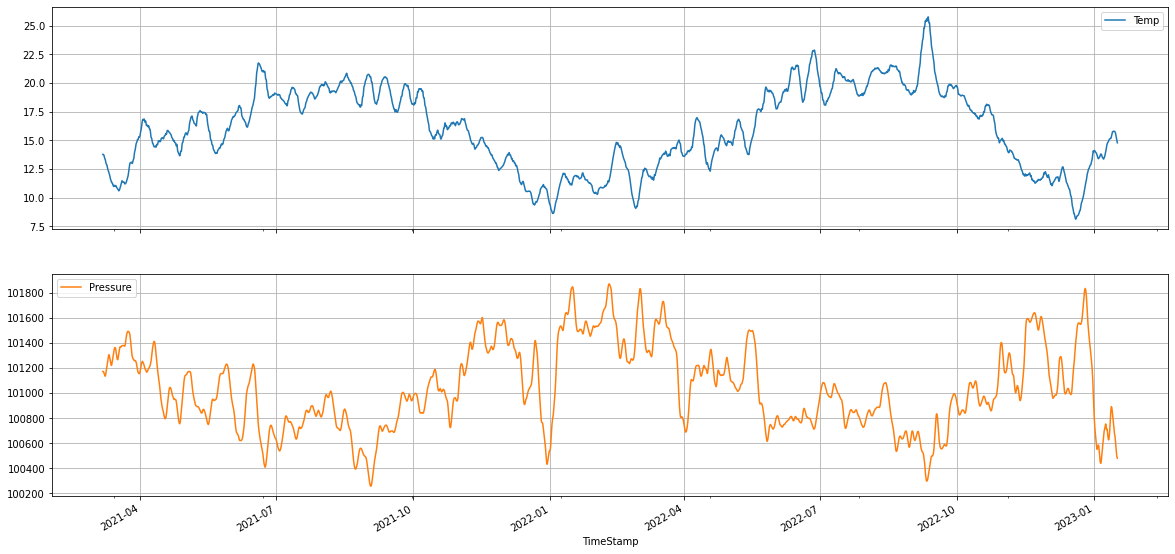

In [14]:
# 7 days rolling average
axs = sensorLog.rolling(7*24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True)

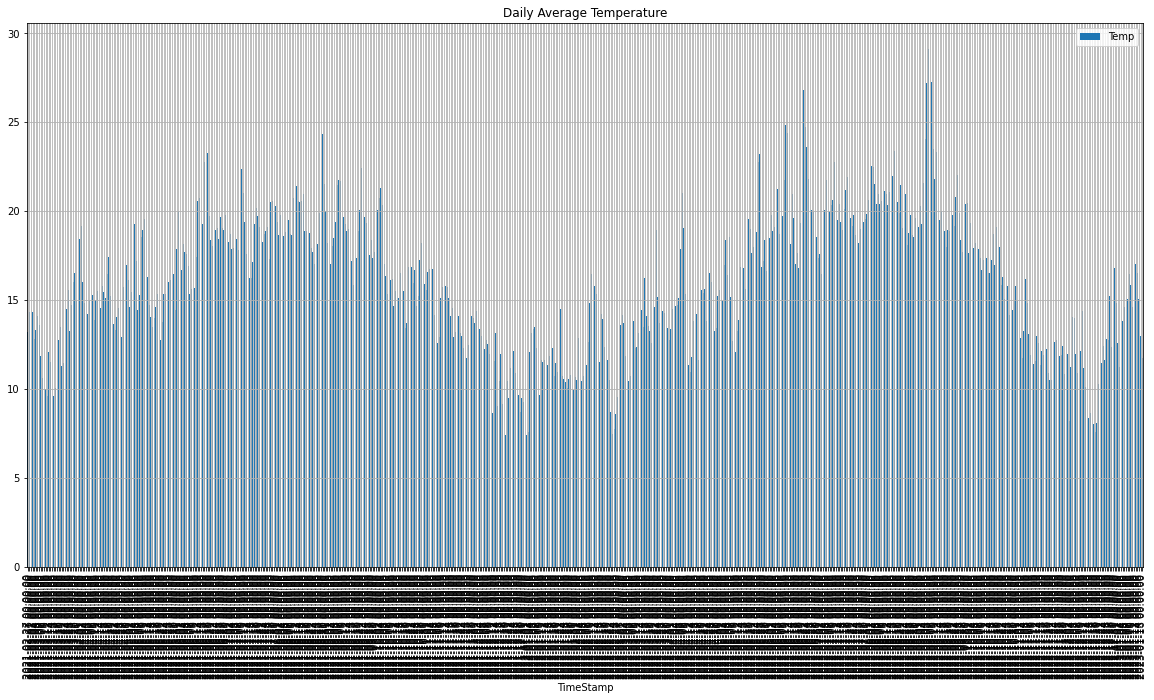

In [15]:
axs = sensorLog.resample('D', level=0).mean().plot.bar(title='Daily Average Temperature',
    y=['Temp'], figsize=(20,10), grid=True)

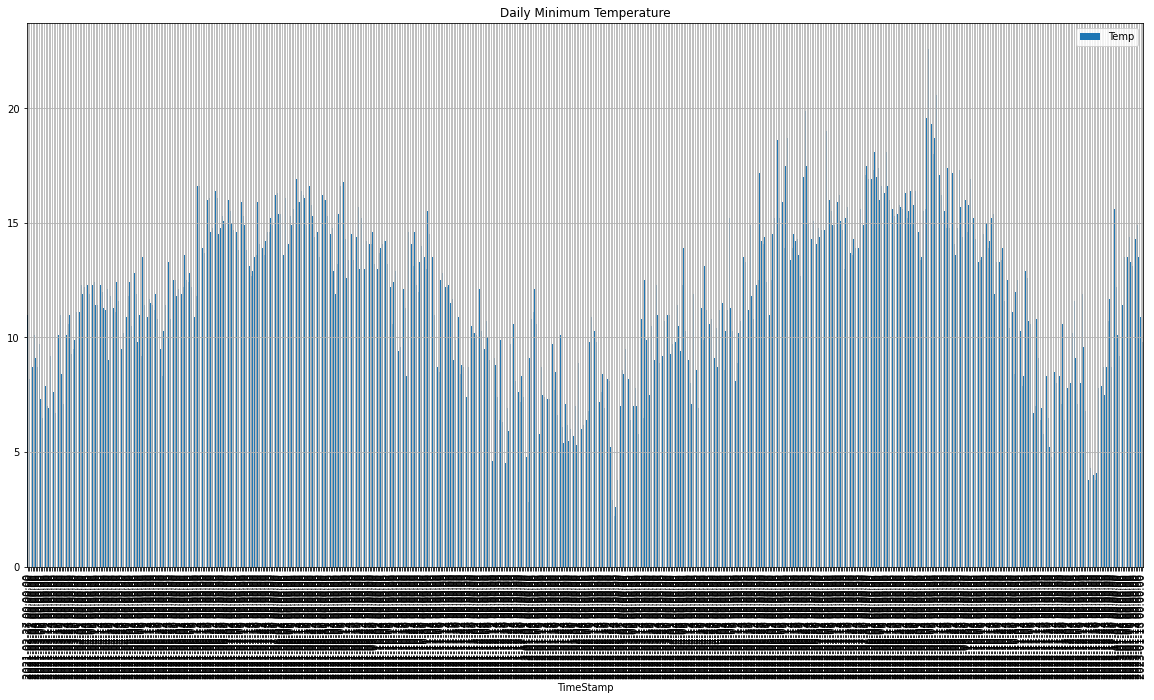

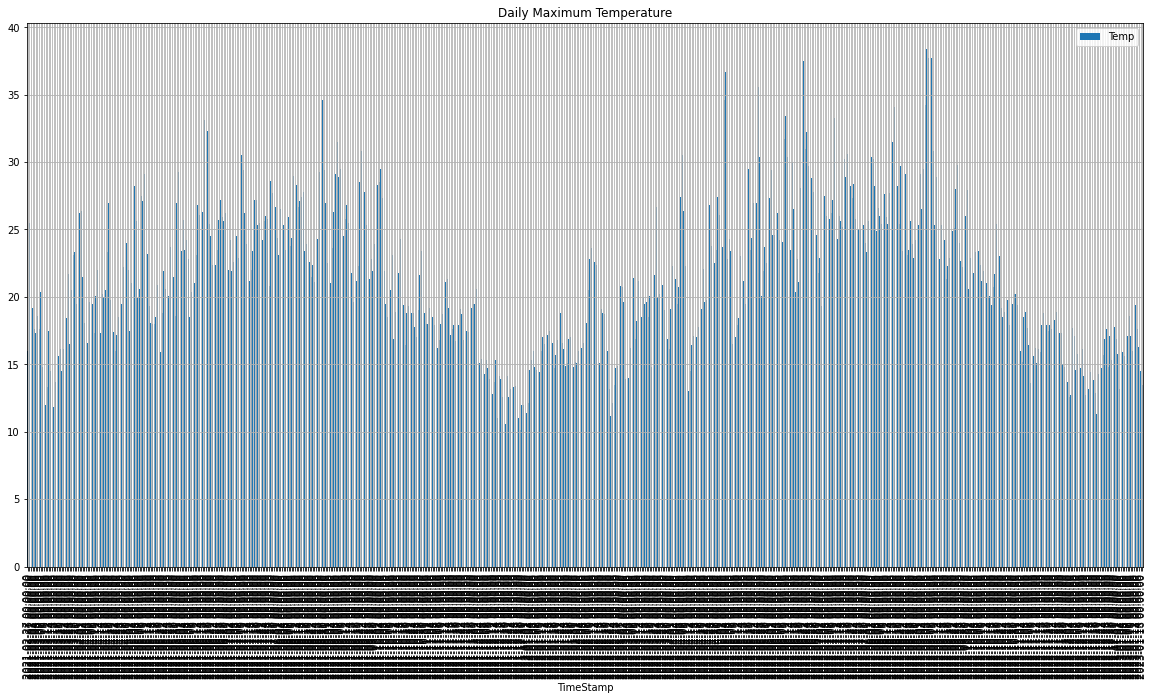

In [16]:
axs1 = sensorLog.resample('D', level=0).min().plot.bar(
    y=['Temp'], figsize=(20,10), grid=True, title='Daily Minimum Temperature')
axs2 = sensorLog.resample('D', level=0).max().plot.bar(
    y=['Temp'], figsize=(20,10), grid=True, title='Daily Maximum Temperature')

In [17]:
# calculate daily min, mean, max temperature using dataframe resampling
minTemp = sensorLog.loc[:yesterday].resample('D', level=0).min().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Min'})
meanTemp = sensorLog.loc[:yesterday].resample('D', level=0).mean().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Mean'})
maxTemp = sensorLog.loc[:yesterday].resample('D', level=0).max().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Max'})
dailyTemp = minTemp.join(meanTemp, how='outer').join(maxTemp, how='outer')

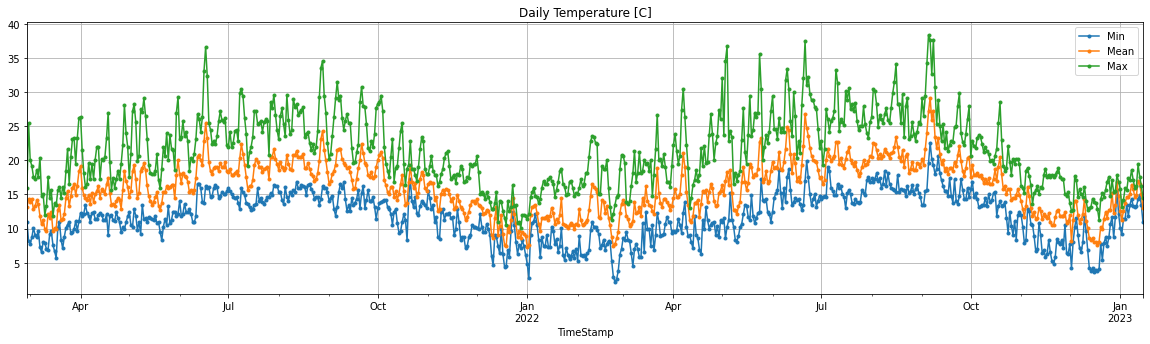

In [18]:
axs = dailyTemp.plot(figsize=(20,5), grid=True, subplots=False, marker='.', title='Daily Temperature [C]')

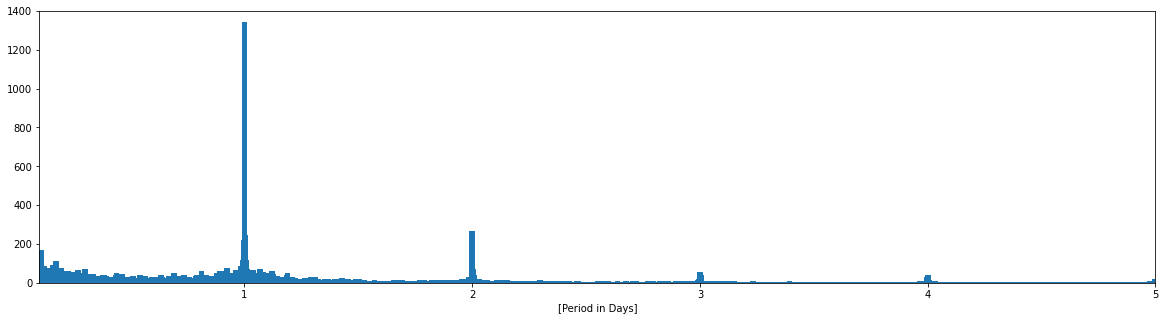

In [19]:
# fft (from https://stackoverflow.com/questions/48622933/python-performing-fft-on-csv-values-using-scipy-documentation)
import numpy as np
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

temperatureSeries = sensorLog.filter(items=['Temp']).values.flatten() #numpy array format
dt = 15/(24*60) #time increment in unit of days (every 15 minutes)

fft = rfft(temperatureSeries)*dt
freq = rfftfreq(len(temperatureSeries),d=dt)

plt.figure(figsize=(20,5))
plt.xlim([0.1,5])
plt.ylim([0,1400])
plt.xlabel('[Period in Days]')
axs = plt.bar(freq, abs(fft), width=0.025)
#axs = plt.plot(freq, abs(fft))

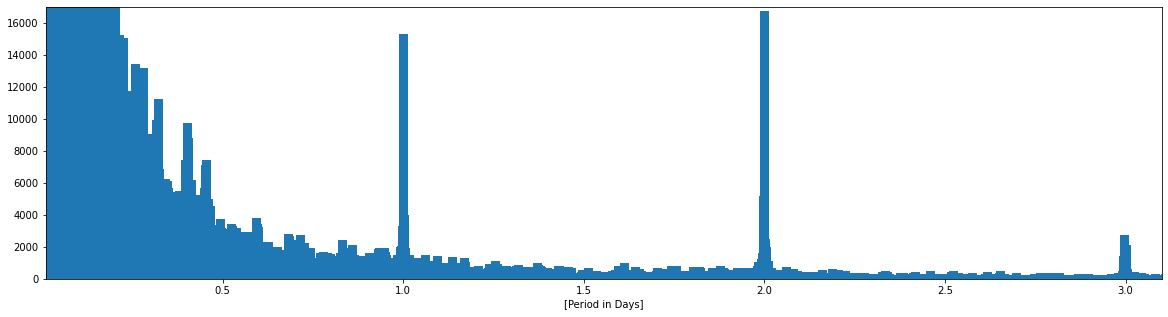

In [20]:
pressureSeries = sensorLog.filter(items=['Pressure']).values.flatten() #numpy array format

fft = rfft(pressureSeries)*dt
freq = rfftfreq(len(pressureSeries),d=dt)

plt.figure(figsize=(20,5))
plt.xlim([0.01, 3.1])
plt.ylim([0, 17000])
plt.xlabel('[Period in Days]')
axs = plt.bar(freq, abs(fft), width=0.025)

In [21]:
freq

array([0.00000000e+00, 1.45395066e-03, 2.90790131e-03, ...,
       4.79963651e+01, 4.79978191e+01, 4.79992730e+01])

In [22]:
#https://www.geeksforgeeks.org/get-the-index-of-maximum-value-in-dataframe-column/
print(sensorLog[['Temp']].idxmin(), sensorLog[['Temp']].idxmax())

Temp   2022-02-24 06:30:00
dtype: datetime64[ns] Temp   2022-09-05 17:00:00
dtype: datetime64[ns]


In [23]:
sensorLog.loc[today:today][['Temp']].idxmin()

Temp   2023-01-16 03:15:00
dtype: datetime64[ns]

In [24]:
# create dataframe with time of minimum and maximum temperature by date
# adapted from https://stackoverflow.com/questions/29569365/how-to-obtain-the-distribution-of-idmax-idmin-in-timeseries-data
sensorLogByDate = sensorLog.groupby(sensorLog.index.date)
timeMinMaxTemp = DataFrame({'MinTemp_Time': sensorLogByDate['Temp'].idxmin().dt.time, 
                            'MaxTemp_Time': sensorLogByDate['Temp'].idxmax().dt.time})

In [25]:
timeMinMaxTemp.tail(10)

,MinTemp_Time,MaxTemp_Time
2023-01-07,21:15:00,14:30:00
2023-01-08,00:00:00,14:00:00
2023-01-09,21:30:00,14:30:00
2023-01-10,10:15:00,15:00:00
2023-01-11,07:15:00,20:15:00
2023-01-12,08:00:00,15:15:00
2023-01-13,10:30:00,00:00:00
2023-01-14,22:00:00,14:15:00
2023-01-15,23:45:00,12:45:00
2023-01-16,03:15:00,13:45:00


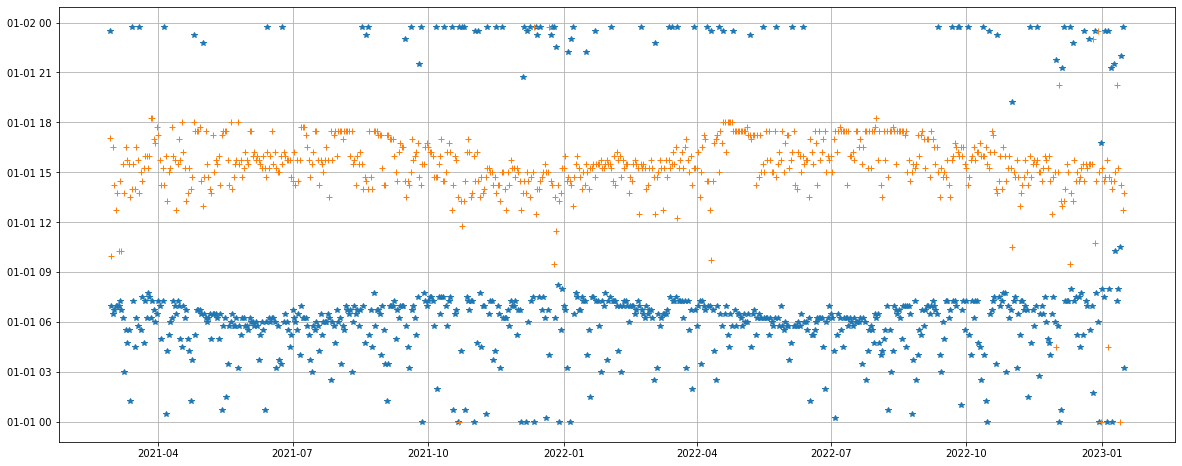

In [26]:
# plot the min/max temp times by date
minTemp_Time = to_datetime(timeMinMaxTemp.MinTemp_Time, format='%H:%M:%S') #.dt.time
maxTemp_Time = to_datetime(timeMinMaxTemp.MaxTemp_Time, format='%H:%M:%S') #.dt.time
plt.figure(figsize=(20,8))
plt.plot(timeMinMaxTemp.index, minTemp_Time, marker='*', linestyle='None')
plt.plot(timeMinMaxTemp.index, maxTemp_Time, marker='+', linestyle='None')
plt.grid()

https://stackoverflow.com/questions/58263983/how-to-plot-date-in-x-axis-time-in-y-axis-with-pandas-matplotlib-and-present-ti

(add also sunrise sunset times)

In [27]:
minTemp_Time

2021-02-27   1900-01-01 23:30:00
2021-02-28   1900-01-01 07:00:00
2021-03-01   1900-01-01 06:30:00
2021-03-02   1900-01-01 06:45:00
2021-03-03   1900-01-01 07:00:00
                     ...        
2023-01-12   1900-01-01 08:00:00
2023-01-13   1900-01-01 10:30:00
2023-01-14   1900-01-01 22:00:00
2023-01-15   1900-01-01 23:45:00
2023-01-16   1900-01-01 03:15:00
Name: MinTemp_Time, Length: 689, dtype: datetime64[ns]

In [28]:
sensorLog.tail(50)

,Temp,Pressure,Altitude,Sealevel Pressure
TimeStamp,,,,
2023-01-16 04:45:00,10.2,99405.0,161.43,99406.0
2023-01-16 05:00:00,10.2,99427.0,159.31,99427.0
2023-01-16 05:15:00,10.2,99450.0,157.03,99453.0
2023-01-16 05:30:00,10.3,99450.0,156.86,99448.0
2023-01-16 05:45:00,10.3,99451.0,156.69,99458.0
2023-01-16 06:00:00,10.5,99475.0,154.83,99476.0
2023-01-16 06:15:00,10.5,99499.0,153.31,99493.0
2023-01-16 06:30:00,10.6,99518.0,151.71,99511.0
2023-01-16 06:45:00,10.6,99541.0,149.77,99539.0
